## Formulation
Lets say you have two vector valued random variables $x$ and $y$ with some joint density $p(x,y)$.  Assume you can generate samples of $(x,y)$.

Let $r_i^{(k)}$ denote component $i$ of the random variable $r$ in layer $k$ of the normalizing flow.   Using a RealNVP approach, each layer of the transformation takes the form
$$
\left[\begin{array}{c}r_{0:d}^{(k+1)}\\ r_{d+1:D}^{(k+1)} \end{array}\right] = P\left[\begin{array}{c}r_{0:d}^{(k)}\\ b\left(r_{0:d}^{(k)}\right) + s\left(r_{0:d}^{(k)}\right)r_{d+1:D}^{(k)} \end{array}\right],
$$
where $P$ is a permutation matrix.

In [15]:
%matplotlib inline

import logging
logging.getLogger('tensorflow').disabled = True

import sys
sys.path.append("../../TransportNets")

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import h5py
import random


from Models.NVP import NVP
from Probability.Distributions import RotatedBanana
from Probability.MCMC import MH2d

tfd = tfp.distributions
tfb = tfp.bijectors

In [28]:
N = 6000
batch_size = 50
n_class = 3
n_params = 2
n_total = n_class + n_params

tile_tensor = tf.constant([N//n_class,1])

X1 = tf.random.normal([N//n_class,2], mean=[-1.0,-1.0], stddev=0.3)
Y1_one_hot = tf.constant([[0,0,1]],tf.float32)
Y1 = tf.tile(Y1_one_hot,tile_tensor) #+ tf.random.normal([N//2,2],stddev=0.05)
YX1 = tf.concat([Y1,X1],axis=-1)

X2 = tf.random.normal([N//n_class,2], mean=[1.0,-1.0], stddev=0.3)
Y2_one_hot = tf.constant([[0,1,0]],tf.float32)
Y2 = tf.tile(Y2_one_hot,tile_tensor) #+ tf.random.normal([N//2,2],stddev=0.05)
YX2 = tf.concat([Y2,X2],axis=-1)

X3 = tf.random.normal([N//n_class,2], mean=[0.0,1.0], stddev=0.3)
Y3_one_hot = tf.constant([[1,0,0]],tf.float32)
Y3 = tf.tile(Y3_one_hot,tile_tensor) #+ tf.random.normal([N//2,2],stddev=0.05)
YX3 = tf.concat([Y3,X3],axis=-1)

YX = tf.concat([YX1,YX2,YX3],axis=0)
dataset = tf.data.Dataset.from_tensor_slices(YX)
dataset = dataset.shuffle(buffer_size=N).batch(batch_size)

Text(0.5, 1.0, 'Training Data')

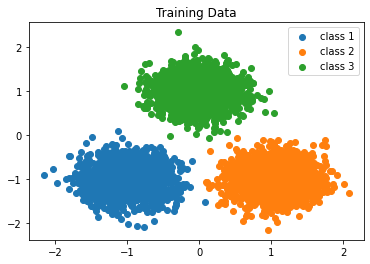

In [30]:
plt.scatter(X1[:,0],X1[:,1],label='class 1')
plt.scatter(X2[:,0],X2[:,1],label='class 2')
plt.scatter(X3[:,0],X3[:,1],label='class 3')
plt.legend()
plt.title('Training Data')

### Define an NVP-based normalizing flow

In [32]:
# Create model object
num_layers = 12
permutations = []
y_permutations = list(np.arange(n_class))
x_permutations = list(np.arange(n_class,n_total))
for i in range(num_layers):
    random.shuffle(x_permutations)
    permutations.append(y_permutations+x_permutations)

nvp = NVP(num_masked=4, output_dim=n_total, num_layers=num_layers, neuron_list=[100,100], permutations=permutations)
# Create optimizer and compile nvp with it
opt = tf.keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-06)
nvp.compile(opt)
# Perform a forward pass to initialize variables
_ = nvp(tf.random.normal([1,n_total]))
nvp.summary()

Model: "NVP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 129,734
Trainable params: 129,734
Non-trainable params: 0
_________________________________________________________________


### Train the model using ADAM

In [33]:
# Train the model with the new callback
n_epochs = 25
nvp.batch_norm_mode(True)
history = nvp.fit(dataset, epochs=n_epochs)  # Pass callback to training
# Set the training variables to not update when doing passes
nvp.batch_norm_mode(False)

Epoch 1/25
120/120 [==============================] - 5s 42ms/step - Negative Log Likelihood: 2.8178
Epoch 2/25
120/120 [==============================] - 5s 41ms/step - Negative Log Likelihood: 2.3475
Epoch 3/25
120/120 [==============================] - 5s 42ms/step - Negative Log Likelihood: 2.3379
Epoch 4/25
120/120 [==============================] - 5s 44ms/step - Negative Log Likelihood: 2.3313
Epoch 5/25
120/120 [==============================] - 5s 45ms/step - Negative Log Likelihood: 2.3275
Epoch 6/25
120/120 [==============================] - 5s 40ms/step - Negative Log Likelihood: 2.3254
Epoch 7/25
120/120 [==============================] - 5s 41ms/step - Negative Log Likelihood: 2.3247
Epoch 8/25
120/120 [==============================] - 5s 40ms/step - Negative Log Likelihood: 2.3190
Epoch 9/25
120/120 [==============================] - 5s 42ms/step - Negative Log Likelihood: 2.3300
Epoch 10/25
120/120 [==============================] - 5s 39ms/step - Negative Log Likeliho

### Plot the training history

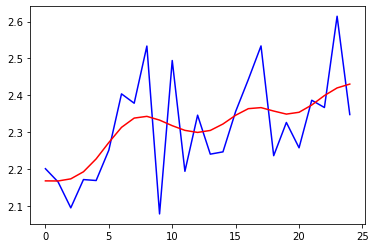

In [34]:
from scipy.ndimage.filters import gaussian_filter1d
ysmoothed = gaussian_filter1d(history.history['Negative Log Likelihood'], sigma=2)
plt.plot(history.history['Negative Log Likelihood'],'b')
plt.plot(ysmoothed, color = 'r')

## Sampling $p(x|y)$ using triangular structure

In [35]:
# We want to draw condition samples from about y = y^*
N_c = 1000
y0 = tf.zeros([1,n_params])

y1_star = tf.reshape([0.0,0.0,1.0],[-1,n_class])
r1 = nvp.inverse(tf.concat([y1_star,y0],-1))[0,:n_class]
cond_ref_samps1 = tf.concat([r1*tf.ones([N_c,n_class]), tf.random.normal([N_c,n_params])], axis=-1)
cond_tgt_samps1 = nvp(cond_ref_samps1)
cond_x1 = cond_tgt_samps1[:,n_class:]

y2_star = tf.reshape([0.0,1.0,0.0],[-1,n_class])
r2 = nvp.inverse(tf.concat([y2_star,y0],-1))[0,:n_class]
cond_ref_samps2 = tf.concat([r2*tf.ones([N_c,n_class]), tf.random.normal([N_c,n_params])], axis=-1)
cond_tgt_samps2 = nvp(cond_ref_samps2)
cond_x2 = cond_tgt_samps2[:,n_class:]

y3_star = tf.reshape([1.0,0.0,0.0],[-1,n_class])
r3 = nvp.inverse(tf.concat([y3_star,y0],-1))[0,:n_class]
cond_ref_samps3 = tf.concat([r3*tf.ones([N_c,n_class]), tf.random.normal([N_c,n_params])], axis=-1)
cond_tgt_samps3 = nvp(cond_ref_samps3)
cond_x3 = cond_tgt_samps3[:,n_class:]

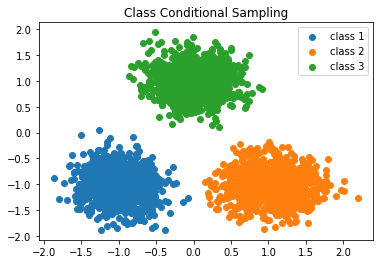

In [36]:
plt.scatter(cond_x1[:,0],cond_x1[:,1],label='class 1')
plt.scatter(cond_x2[:,0],cond_x2[:,1],label='class 2')
plt.scatter(cond_x3[:,0],cond_x3[:,1],label='class 3')
plt.title('Class Conditional Sampling')
plt.legend()
plt.savefig('gaussian_mixture_sampling_3.png')

In [49]:
inputs = tf.constant([0.0,0.0,1.0,-1.1,-1.1],shape=[1,n_total])
nvp.prob(inputs)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([inf], dtype=float32)>